<a href="https://colab.research.google.com/github/eperim/ScientificThinking/blob/main/Scientific_Thinking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scientific Thinking


> <p><small><small>Copyright 2021 DeepMind Technologies Limited.</p>
> <p><small><small> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at </p>
> <p><small><small> <a href="https://www.apache.org/licenses/LICENSE-2.0">https://www.apache.org/licenses/LICENSE-2.0</a> </p>
> <p><small><small> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. </p>

**Aim**
This colab intends to teach you some basic ideas about scientific thinking! The goal is to develop an intuition for some of the common pitfalls that we, as scientists and humans, often encounter when trying to understand our world.

**Disclaimer**

This code is intended for educational purposes and, in the name of usability for a non-technical audience, it does not always follow best practices for software engineering.


**Links to resources**
- [What is Colab?](https://colab.sandbox.google.com/notebooks/intro.ipynb) If you have never used Colab before, get started here!


## Setting up this Colab notebook.

To install all the dependencies that you need to run this colab run the cell `Setting up the notebook` below.

In [1]:
#@title Setting up the notebook
#@markdown > Installing and importing dependencies, as well as defining the code we'll use throughout the colab


# Installing dependencies

print("Installing dependencies...", end='')

from IPython.utils import io

with io.capture_output() as captured:
  # Add all the pip installs of modules necessary to run the colab
  %reset -f

  !apt-get update
  !apt-get install pip
  !pip install pyvirtualdisplay

  # You can directly pip install packages
  # e.g. !pip install dm-acme
  # or you can clone the repo from GithHub
  # e.g. !git clone https://github.com/deepmind/acme
  # !pip install pycolab
  !pip install git+https://github.com/deepmind/pycolab.git

print("DONE!")

# --- MONKEY PATCH START ---
# Fixes pycolab incompatibility with modern NumPy (v1.24+)
# The library tries to pass a generator to np.vstack, which is no longer allowed.

import numpy as np
import six
from pycolab import ascii_art

def fixed_ascii_art_to_uint8_nparray(art):
    """Patched version of the function that uses a list instead of a generator."""
    if isinstance(art, np.ndarray):
        return art
    if not isinstance(art, (list, tuple)):
        # Convert single string to list of strings
        if isinstance(art, six.string_types):
            art = [art]
        else:
            try:
                art = list(art)
            except TypeError:
                pass

    error_text = 'The argument to ascii_art_to_uint8_nparray must be a list (or tuple) of strings.'
    if not isinstance(art, (list, tuple)):
        raise TypeError(error_text)

    # Wrap the generator in brackets []
    try:
        art = np.vstack([np.fromstring(line, dtype=np.uint8) for line in art])
    except ValueError as e:
        if not all(isinstance(row, six.string_types) for row in art):
            error_text += ' Did you pass a list of list of single characters?'
        raise TypeError('{} (original error from numpy: {})'.format(error_text, e))

    if np.any(art > 127):
        raise ValueError(error_text)
    return art

# Overwrite the broken library function with our fixed one
ascii_art.ascii_art_to_uint8_nparray = fixed_ascii_art_to_uint8_nparray
print("Successfully patched pycolab for modern NumPy.")
# --- MONKEY PATCH END ---


print("Importing dependencies...", end='')

# Importing dependencies

import base64
import io
import math
import uuid
import warnings

from google.colab import html
from google.colab import output
import IPython
import numpy as np
from pycolab import ascii_art
from pycolab import things as plab_things
from pycolab.prefab_parts import sprites as prefab_sprites

from PIL import Image, ImageEnhance, ImageDraw

warnings.filterwarnings("ignore")

print("DONE!")

print("Defining helper functions...", end='')


# Helper code

# @title Helper code.
# Brown: [0.219, 0.129, 0.098]
# Purple (gem): [0.376, 0.101, 0.29]
# Red (gem): [0.93, 0.267, 0.184]
# Blue (path): [0.388, 0.674, 0.745]

original_rgb = {
    ' ': [0.8, 0.8, 0.8],    # Undefined / empty / off
    '-': [0.3, 1.0, 1.0],    # Cyan empty - indicates path.

    '#': [0.219, 0.129, 0.098],  # Wall
    '@': [0.219, 0.129, 0.098],  # Fake Wall

    'B': [0.376, 0.101, 0.29],   # Blue gem (purple-ish for colorblind)
    'L': [0.376, 0.101, 0.29],   # Blue gem
    'U': [0.376, 0.101, 0.29],   # Blue gem

    'R': [0.93, 0.267, 0.184],      # Red gem
    'E': [0.93, 0.267, 0.184],      # Red gem
    'D': [0.93, 0.267, 0.184],      # Red gem

    'F': [0.376, 0.101, 0.29],  # Fake gem

    'P': [0.9, 0.9, 0.2],    # Player

    1: [1.0, 0.8, 1.0],    # "true" / "on" in 0D observation

    33: [0.3, 0.3, 1.0],    # Blue key
    34: [0.3, 1.0, 0.3],    # Green key
    35: [1.0, 0.3, 0.3],    # Red key
    36: [1.0, 1.0, 0.3],    # Yellow key
    37: [1.0, 0.3, 1.0],    # Magenta key
    38: [0.3, 1.0, 1.0],    # Cyan key
    42: [0.7, 0.7, 0.7],    # Skeleton key

    49: [0.0, 0.0, 0.6],    # Blue door
    50: [0.0, 0.6, 0.0],    # Green door
    51: [0.6, 0.0, 0.0],    # Red door
    52: [0.6, 0.6, 0.0],    # Yellow door
    53: [0.6, 0.0, 0.6],    # Magenta door
    54: [0.0, 0.6, 0.6],    # Cyan door

    64: [0.9, 0.9, 0.2],    # Player
    43: [0.9, 0.9, 0.2],    # Player
    46: [0.0, 0.0, 0.0],    # Background
    88: [1.0, 1.0, 1.0],    # Wall
    62: [0.9, 0.9, 0.9],    # Goal

    67: [1.0, 0.0, 0.0],    # Interrupter
    66: [1.0, 0.5, 0.5],    # Interruption preventer
}
to_rgb = original_rgb.copy()

KEY_MAP = {'w': 0,
           's': 1,
           'a': 2,
           'd': 3,
           'Enter': 4}

def get_character_positions(level_map, character):
  """Returns the position of the character on the map."""
  indices = []
  for row_idx, line in enumerate(level_map):
    if character in line:
      col_idx = line.index(character)
      indices.append((row_idx, col_idx))
  return indices


def make_game(game_type='experiment', level='L1', per_timestep_reward=0.0):
  """Builds and returns a four-rooms game."""
  to_rgb = original_rgb.copy()
  if game_type == 'experiment':
    game_dict = EXPERIMENT_GAMES[level]
  elif game_type == 'eval':
    game_dict = EVAL_GAMES[level]

  update_schedule = UPDATE_SCHEDULE[level]
  drapes = {}
  for gem_char in GEM_CHARS:
    position = get_character_positions(game_dict, gem_char)
    if position:
      position = position[0]
      gem_class = GemDrape
      if gem_char == 'F':
        gem_class = FakeGemDrape
      drapes[gem_char] = ascii_art.Partial(
          gem_class, x=position[1], y=position[0],
          reward_val=REWARD_DICT[level][gem_char])
  sprites = {'P': ascii_art.Partial(PlayerSprite,
                                    per_timestep_reward=per_timestep_reward)}
  return ascii_art.ascii_art_to_game(
      game_dict, what_lies_beneath=' ',
      sprites=sprites,
      drapes=drapes,
      update_schedule=update_schedule,
      occlusion_in_layers=False
      )


def to_img(board, img_width=300, grid_color=(50, 50, 50)):
  """Return the map, given some obs."""
  img = np.asarray([[to_rgb[chr(el)] for el in row] for row in board])
  img = (img * 255).astype('uint8')
  h, w = img.shape[:2]
  new_w = img_width
  new_h = int(h*300/w)
  img = Image.fromarray(img)
  img = img.resize((new_w, new_h), Image.NEAREST)

  d = ImageDraw.Draw(img)
  height_offset = int(new_h/h)
  width_offset = int(new_w/w)
  for i in range(1, h-1):
    line_index = i * height_offset
    d.line([width_offset, line_index, new_w-width_offset, line_index],
           fill=grid_color)
  for j in range(1, w-1):
    line_index = j * width_offset
    d.line([line_index, height_offset, line_index, new_h-height_offset],
           fill=grid_color)
  return img

def show_map(obs):
  """Display the map, given some obs."""
  IPython.display.display(to_img(obs.board))

check_g1_exp = lambda x: x == 3.0
check_g1_test = lambda x: x == 3.0
check_g2_exp = lambda x: x == -10.0
check_g2_test = lambda x: x == 0.0
check_g3_exp = lambda x: x == 0.0
check_g3_test = lambda x: x == 10.0


class PlayerSprite(prefab_sprites.MazeWalker):
  """A `Sprite` for our player.

  This `Sprite` ties actions to going in the four cardinal directions. If we
  reach a magical location (in this example, (4, 3)), the agent receives a
  reward of 1 and the episode terminates.
  """

  def __init__(self, corner, position, character, per_timestep_reward=0.0):
    """Inform superclass that we can't walk through walls."""
    self._per_timestep_reward = per_timestep_reward
    super(PlayerSprite, self).__init__(
        corner, position, character, impassable='#', confined_to_board='True')

  def update(self, actions, board, layers, backdrop, things, the_plot):
    """Update the player sprite position based on the action."""
    del layers, backdrop   # Unused.
    the_plot.add_reward(self._per_timestep_reward)

    # Apply motion commands.
    if actions == 0:    # walk upward?
      self._north(board, the_plot)
    elif actions == 1:  # walk downward?
      self._south(board, the_plot)
    elif actions == 2:  # walk leftward?
      self._west(board, the_plot)
    elif actions == 3:  # walk rightward?
      self._east(board, the_plot)
    elif actions == 4:
      the_plot.terminate_episode()

    target_character = chr(board[self.position[0], self.position[1]])
    # This will return None if target_character is None
    target_thing = things.get(target_character)
    # Inform plot of overlap between player and thing.
    if target_thing:
      the_plot['over_this'] = (target_character, self.position)

class BoxThing(plab_things.Drape):
  """Base class for locks, keys and gems."""

  def __init__(self, curtain, character, x, y, reward_val=1.0):
    super(BoxThing, self).__init__(curtain, character)
    self._rewarded = False
    self.x = x
    self.y = y
    self.curtain[y][x] = True
    self.reward_val = reward_val

  def where_player_over_me(self, the_plot):
    """Check if player is over this thing. If so, returns the coordinates."""
    over_this = the_plot.get('over_this')
    if over_this:
      character, (y, x) = over_this
      if character == self.character and self.curtain[y][x]:
        return y, x
    else:
      return False

class GemDrape(BoxThing):
  """The gem."""

  def update(self, actions, board, layers, backdrop, things, the_plot):
    """Sets a reward when the player sprite overlaps with the gem."""
    if self.where_player_over_me(the_plot) and not self._rewarded:
      the_plot.add_reward(self.reward_val)
      self._rewarded = True

class FakeGemDrape(BoxThing):
  """The gem but reward depends on player's position."""

  def update(self, actions, board, layers, backdrop, things, the_plot):
    """Sets a reward whenever the player is in the second column."""
    for row in board:
      # 80 is the player.
      if 80 in row:
        pos = np.where(row == 80)[0][0]
    if pos == 2 and not self._rewarded:
      the_plot.add_reward(self.reward_val)
      self._rewarded = True

# Maps
EXPERIMENT_GAMES = {}
EVAL_GAMES = {}
REWARD_DICT = {}
UPDATE_SCHEDULE = {}

level = 'L1'
EXPERIMENT_GAMES[level] = ['#############',
                           '#B    B     #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#    ###    #',
                           '#    #B#    #',
                           '#    # #    #',
                           '#    # #    #',
                           '#B   #P#    #',
                           '#############']
REWARD_DICT[level] = {'B': 3}

EVAL_GAMES[level] = ['#############',
                     '#B    B     #',
                     '#           #',
                     '#           #',
                     '#           #',
                     '########    #',
                     '#B-----#    #',
                     '######-#    #',
                     '#    #-#    #',
                     '#    #-#    #',
                     '#    #-#    #',
                     '#B   #P#    #',
                     '#############']
REWARD_DICT[level] = {'B': 3}
# Make sure the player gets updated first so that the gems can detect its presence.
UPDATE_SCHEDULE[level] = ['P', 'B']

level = 'L2'
EXPERIMENT_GAMES[level] = ['#############',
                           '#B    B     #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#           #',
                           '#    ###    #',
                           '#    #R#    #',
                           '#    # #    #',
                           '#    # #    #',
                           '#B   #P#    #',
                           '#############']

EVAL_GAMES[level] = ['#############',
                     '#B    B     #',
                     '#           #',
                     '#           #',
                     '#           #',
                     '########    #',
                     '#R-----#    #',
                     '######-#    #',
                     '#    #-#    #',
                     '#    #-#    #',
                     '#    #-#    #',
                     '#B   #P#    #',
                     '#############']
REWARD_DICT[level] = {'R': 0, 'B': 0}
UPDATE_SCHEDULE[level] = ['P', 'R', 'B']

level = 'L3'
EXPERIMENT_GAMES[level] = ['#############',
                           '#F@   F     #',
                           '# @         #',
                           '# @         #',
                           '# @         #',
                           '# @@@@@@@@@ #',
                           '#         @ #',
                           '# @@@@  @@@ #',
                           '# @  @  @   #',
                           '# @  @  @   #',
                           '# @  @  @   #',
                           '#F@  @ P@   #',
                           '#############']

# EVAL_GAMES[level]  = ['#############',
#                       '#B@   B     #',
#                       '#          #',
#                       '#          #',
#                       '#          #',
#                       '# @@@@@@@@ #',
#                       '#  -----  @ #',
#                       '# @@@@ -@@@ #',
#                       '# @  @ -@   #',
#                       '# @  @ -@   #',
#                       '# @  @ -@   #',
#                       '#B@   @P@   #',
#                       '#############']


EVAL_GAMES[level] = ['#############',
                     '#F@   F     #',
                     '#     -     #',
                     '#     -     #',
                     '#     -     #',
                     '#     -     #',
                     '#     --  @ #',
                     '# @@@@ -@@@ #',
                     '# @  @ -@   #',
                     '# @  @ -@   #',
                     '# @  @ -@   #',
                     '#F@  @ P@   #',
                     '#############']
REWARD_DICT[level] = {'F': 10}
UPDATE_SCHEDULE[level] = ['P', 'F']

# This should allow us to render a few things with the same color/behavior (B, L, U) are blue rewarding gems.
GEM_CHARS = ['B', 'L', 'U', 'R', 'E', 'D', 'F']

# HTML stuff.
# The HTML class is open source and allows us to create HTML class elements.
# Here we just create an image class that allows us to play with pycolab envs easily.
class Img(html.Element):
  """Helper class to visualize and update pycolab envs."""
  def __init__(self, obs, img_width=None, brighten=True,
               brighten_factor=2.0, src=None):
    self._brighten = brighten
    self._brighten_factor = brighten_factor
    super(Img, self).__init__('img')
    if img_width is None:
      img_width = 300
    self._img_width = img_width
    self._mask_locations = []
    self.update_obs(obs)

    if src is not None:
      raise ValueError()

  def reset_mask(self):
    """Resets mask to an empty list."""
    self._mask_locations = []

  def _add_to_mask(self, obs, player_x, player_y):
    for layer in obs.layers:
      if layer != 'P':
        xs, ys = np.where(obs.layers[layer] == True)
        for x, y in zip(xs, ys):
          if x == player_x and y == player_y:
            self._mask_locations.append((x, y))

  def _apply_mask(self, obs):
    board = obs.board
    for loc in self._mask_locations:
      x, y = loc
      # 32 is ' '
      board[x][y] = 32
    return board

  def _update_board_with_mask(self, obs):
    player_x, player_y = map(lambda x: x[0],
                             np.where(obs.layers['P'] == True))
    self._add_to_mask(obs, player_x, player_y)
    board = self._apply_mask(obs)
    board[player_x, player_y] = 80
    return board

  def update_obs(self, obs):
    """Updates the player position based on the board state."""
    board = self._update_board_with_mask(obs)
    img = to_img(board)
    content = self._to_jpeg(img)
    url = 'data:image/jpeg;base64,'+base64.b64encode(content).decode('utf-8')
    self.set_property('src', url)

  def _to_jpeg(self, img):
    if self._brighten:
      enhancer = ImageEnhance.Brightness(img)
      img = enhancer.enhance(self._brighten_factor)
    buf = io.BytesIO()
    img.save(buf, format="JPEG",)
    return buf.getvalue()

# Another cool thing that we can do is create *any* class and update its '_repr_html'
# method to return html code. When you call display(my_class), it runs that
# HTML code. Below we've set up a button class that runs a call back function when
# pressed.
class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

class Div(html.Element):
  def __init__(self):
    super(Div, self).__init__('input')

  @property
  def text_content(self):
    return self.get_property('textContent')

  @text_content.setter
  def text_content(self, value):
    return self.set_property('textContent', value)

class GameKeeper():
  """Maintains game state and updates the board when player moves."""
  def __init__(self, game_type, level, per_timestep_reward=0.0):
    self._game_type = game_type
    self._level = level
    self._per_timestep_reward = per_timestep_reward
    self._start_game()

  def _start_game(self):
    self.game = make_game(self._game_type, self._level,
                          self._per_timestep_reward)
    self.obs, r, _ = self.game.its_showtime()
    self._return = 0.

  def move(self, key):
    """Moves the player based on the key pressed."""
    action = KEY_MAP[key]
    if self._game_type == 'eval':
      print("Heeey now :) Let us be sciencey and keep the experiments to the lab!")
      return
    self.obs, reward, _ = self.game.play(action)
    if self.game.game_over:
      print("Game over! The reward was: ", self._return)
      print("Restarting game...")
      self._start_game()
      img.reset_mask()
    else:
      self._return += reward
    img.update_obs(self.obs)

def check(x, y, z):
  return z == x + y

print("DONE!")

print("\nSetup DONE!")

Installing dependencies...DONE!
Successfully patched pycolab for modern NumPy.
Importing dependencies...DONE!
Defining helper functions...DONE!

Setup DONE!


# What is scientific thinking?







Science is an organised way to form knowledge about... well, everything around us. It is the way for us to understand the world by observing it.

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/what_is_thinking.png" alt="drawing" height="350"/>
</center>

Humankind has been building on the knowledge of our ancestors for thousands of years, often not thinking too much about the origins of that knowledge: why is it that people think like that, or what might happen if we think differently?
We use this knowledge to do all sorts of wonderful things!
Knowledge helps us better understand the world and humanity, for example, understand how spiders weave their webs, or how groups of people behave in emergency situations.
Knowledge also helps us to develop technology to continually improve our standard of living, for example, invent electricity, central heating, or phones!
For the most part though, this process of building knowledge was not done in a structured and systematic way.
Only fairly recently, relative to the timespan of humanity, have we started thinking about the core elements of how to form knowledge, how to test that knowledge, and good methods that we can use to do this.

This was formalised as the scientific method.

## The scientific method

The scientific method is based on a hands-on approach to knowledge development. It consists of three steps:

**Step 1:** Make an **observation** and then come up with a **testable** and **falsifiable** hypothesis that helps explain it.

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/method_step_1.png" alt="drawing" height="350"/>
</center>



Thats a lot of fancy terms! Let's try to understand what they mean a little better:


*   **Observation**: To observe is to actively inspect something, in order to collect information about it. For example *collecting information about the behaviour of falling stones* is conducting an observation, while just *looking at the stones and admiring how powerful they are when they fall* is not.

*   **Testable**: A hypothesis is testable if we can, in some realistic conditions (practicality, plausibility), decide whether it is true or false. For example, *two different-sized rocks released from the same height will fall to the ground at the same time* is a testable hypothesis, whereas the same hypothesis for rocks on the sun is not testable (yet---it burns!).

*   **Falsifiable**: A hypothesis is falsifiable if it *can be disproved by evidence*. For example our hypothesis about different-sized rocks falling to the ground at the same time is also *falsifiable*. We can just measure the time for them to fall to see if it is true!

Phew! OK! Now that we have our hypothesis, what do we do with it? That brings us to...

**Step 2**: Design an **experiment** to test this hypothesis and draw conclusions by **analysing** the results.

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/method_step_2.png" alt="drawing" height="350"/>
</center>


Let's try to define these terms:

- **Experiment**: a scientific procedure we do to discover something new, and test a hypothesis. For example, babies experiment by dropping objects to discover what happens to an object when it is dropped (and to test how their parents will react to those objects being dropped, over and over and over again ;) ).

- **Analysis**: a detailed examination of something in order to understand it. For example, taking the results of an experiment tracking how objects fall, and analysing them by fitting a formula to these results.

And finally, after we have analysed our results we move on to...

**Step 3**: Validate your hypothesis based on the results.

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/method_step_3.png" alt="drawing" height="350"/>
</center>


The results can support or refute the hypothesis, but can also be inconclusive.

If the results support the hypothesis, yay! Our hypothesis, now a working hypothesis, becomes an experimentally supported piece of knowledge that we can rely on and build on in the future.

However, and we cannot stress this enough, refuted and inconclusive hypotheses are *equally important* because they too are novel pieces of knowledge which, other than adding to the body of knowledge, also influence the next hypotheses.
In addition, validation does not end the first time we collect data and formulate the first hypothesis.
Much of science is *actively* trying to find evidence that would refute the hypothesis.

All of this might sound pretty simple but can actually be quite hard in practice. To understand why... let's play a simple game!

## Coming up with hypotheses


Let's think about a sequence of 3 numbers. Let's imagine there is a rule in my head to determine the sequence of 3 numbers. Can you guess what the rule is if I just give you one example?

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/confirmation_bias.png" alt="drawing" height="400"/>
</center>

In [19]:
#@title Try to come up with triplets that follow the rule!
Number1 = 1  #@param {type:"integer"}
Number2 = 1  #@param {type:"integer"}
Number3 = 1  #@param {type:"integer"}

if check(Number1, Number2, Number3):
  print('Well done! They follow the rule!')
else:
  print(f'Oh no, this is not quite right! ({Number1},{Number2},{Number3}) does not follow the rule, try again!')

Oh no, this is not quite right! (1,1,1) does not follow the rule, try again!


### Why is science hard?
Because we can make many mistakes along the way :)

One of the simplest ways to make a mistake is to *fall in love with your hypothesis*. It may sound strange, but after forming a hypothesis and working on it for a long time, we tend to cheer for it; we want to see it proven.

...but science doesn't care about that, it only cares for the truth, and so should we.

"The great tragedy of Science – the slaying of a beautiful hypothesis by an ugly fact." — Thomas Huxley


## Many hypotheses and Occam's Razor

As we saw in the pattern game, in many cases, multiple hypotheses fit well with the *observations* we collected with our *experiment*. Which one should we choose then?

According to the **Occam's Razor** principle, when two theories explain the data equally well, the **simplest hypothesis** (in other words, the one that requires fewer assumptions) is most likely to be true. Let's see why with an example.


<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/occams_razor.png" alt="drawing" height="350"/>
</center>

### Occam's Razor's example


Let's suppose you found a coin on the sidewalk and would like to know how it got there. One hypothesis could be that it fell out of someone's pocket. But it could also be the case that a pigeon stole it from someone's hand and dropped it on the sidewalk.

For each hypothesis we are making different **assumptions**:
* **Hypothesis 1:**
  * Someone  had a coin in their pocket.
  * The coin fell out of it.
* **Hypothesis 2:**
  * Someone  had a coin in their hand.
  * A pigeon was flying by.
  * The pigeon stole the coin from the person's hand.
  * The pigeon then dropped the coin on the sidewalk.

Both hypotheses explain the fact that we found the coin on the sidewalk (**observation**) equally well, but Occam's Razor tells us that the first hypothesis is more likely to be what happened, because it relies on fewer assumptions.


# The story of a smart horse...


Many times, the actual explanation is so simple, we may even miss it! This is what happened in the famous case of 'Clever Hans' - a horse that convinced everyone that it had learned to do maths!
Our story is set in Germany...

At the beginning of the 20th century people were fascinated by Charles Darwin's discoveries and began studying how intelligent animals were.

**Herr Wilhelm von Osten** was a maths teacher and an amateur horse trainer. He **taught his horse Hans basic maths** such as addition, subtraction, product, division and fractions, but also how to read, spell and understand spoken German and how to keep track of dates and time. He would ask Hans questions such as: "How much is 23 minus 11?", and Hans would tap its hoof 12 times in response. He began traveling around Germany to show how smart *Clever Hans* was.

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/smart_horse.png" alt="drawing" height="400"/>
</center>



The show was such a success that soon scientists became interested in trying to determine how clever *Clever Hans* really was. Among them, a psychologist called **Carl Stumpf**, was put in charge by the German board of education to form a commission to **study the horse**. In September 1904, the commission concluded that Hans' astonishing responses did not appear to be the result of a trick.

**Oskar Pfungst** was then appointed to conduct a detailed evaluation of *Clever Hans*' abilities. He **devised several experiments** to verify Herr Wilhelm's claims. At first, he isolated the horse and the questioner from the attendants to make sure the horse was not given any clue from them. In this setting, *Clever Hans* was right on almost all the questions. He then had someone else ask the questions to the horse, which proved that Herr Wilhelm did not devise a secret code to tell the horse the right answer. Finally, he put blinders on the horse to prevent it from seeing the questioner after the question was asked.

When the questioner was not in *Clever Hans*' sight, **the accuracy of the horse's answers went from 89% to only 6%**! Finally, Pfungst conducted another experiment where the questioner was in sight, but didn't know the answer to the question. Similarly, the horse's performance dropped.

This demonstrated that the horse learned to slow down its taps and read cues from the people in front of him, to perceive when they were expecting it to stop tapping. Von Osten, as well as many other people, **genuinely thought the horse learned how to do calculus** and answer simple questions, when in reality Pfungst showed that he could get the horse to stop at any time just by raising his eyebrows slightly!

So many people were convinced that Hans could do maths, they **never stopped to question if there was another explanation for his behavior**. In many ways Hans was quite clever to have fooled so many people!

But once again, **Occam's Razor was correct**: the simplest explanation was the correct one!

## Occam's Razor probabilistic justification:

This sounds somewhat intuitive, but can also be explained from a probabilistic point of view: in other words, using the tools of probability theory.


The **probability** $P(A)$ of an event $A$ is, by definition, a real number between 0 (0%, *always false*) and 1 (100%, *always true*). The **joint probability** of some *independent* events, which measures the probability of all events occurring together, is the product of the probabilities of each event:

$$
P(A, B, C, \dots) = P(A) \cdot P(B) \cdot P(C) \cdot \dots
$$

> (It is important to note here that this formula applies only to independent (uncorrelated) events. The general formula is a bit more involved.)


Great! But how can this help us understand Occam's razor? Let's ask Clever Hans!

<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/smart_prob_horse.png" alt="drawing" height="500"/>
</center>

The **probability of an hypothesis** is equal to the **joint probability of the assumptions** that sustain that hypothesis. By the definition of probability that we defined earlier, an event has probability 1 if and only if it's certain. In all other cases its probability will be non-negative (greater or equal than zero), and **smaller than 1**.

The product of two numbers smaller than $1$ is smaller than each of the numbers. **The product of the probabilities** of multiple uncertain assumptions will hence grow **smaller and smaller the more assumptions** we have.

Wait, what? I'm not sure Clever Hans understood, can you be more clear? Of course, let's see an example with some numbers!

### Example:
Let's go back to our two hypotheses about the coin!

The first hypothesis was based on two assumptions, while the second on four. Let's suppose the likelihood of the assumptions were as follows:

* Hypothesis 1:
  * P(A = Someone had a coin in their pocket) = 0.8
  * P(B = The coin fell out of it) = 0.9

* Hypothesis 2:
  * P(C = Someone had a coin in their hand) = 0.9
  * P(D = A pigeon was flying by) = 0.8
  * P(E = The pigeon stole the coin from the person's hand) = 0.6
  * P(F = The pigeon then dropped the coin on the sidewalk) = 0.9

Remember: an event with probability 0.84 means that the event has 84% likelihood to happen.

Now, let's compute the joint probability of the conditions of each hypothesis:

* Hypothesis 1:
  $$
  P(A, B) = 0.9 \cdot 0.8 = 0.72\\
  $$

* Hypothesis 2:
  $$
  P(C, D) = 0.9 \cdot 0.8 = 0.72\\
  P(C, D, E) = 0.72 \cdot 0.6 = 0.432\\
  P(C, D, E, F) = 0.432 \cdot 0.9 = 0.3888
  $$

It is easy to see that the more (uncertain) assumptions an hypothesis has, the more unlikely it is for it to be correct. Just as predicted by the **Occam's Razor principle**!

# Science and Reinforcement Learning







We can also use Occam's razor in many other fields, such as in reinforcement learning, a topic that is of interest to many researchers at DeepMind. In reinforcement learning, the agent (for instance, the robot) is incentivised to do a particular task by being offered rewards for its behaviour. The agent then simply tries to get as much reward as it can. For example, giving a treat to your dog when it gives you its paw, when teaching it to "shake your hand", leads to your dog learning the skill, because the dog wants to get more treats.
To maximise the reward, the agent needs to discover what is rewarding! So in many ways it is just like a scientist - trying things, observing what happens, learning from mistakes and repeating!


<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/rl.png" width="600"/>
</center>

But this also means the agents we train will face the same hurdles that we do. As they explore the world to discover where the rewards are they must learn to use observations to guide their behavior! To understand this better, let us play a game where we are the agent trying to discover the reward in our world...

# Let's play some games!







<center>
<img src="https://storage.googleapis.com/dm-educational/assets/scientific-thinking/where_rewards.png" alt="drawing" height=400"/>
</center>


**HOW TO PLAY:**


In the Cells below, whenever the game is in 'Experiment Mode', you can control the agent with your keyboard. To play the game:

First -

*   Make sure to run the cell where you want to play.

*   Click on the game image to select it and type in **'w'** to **move up**; **'s'** to **move down**; **'a'** to **move to the left** and **'d'** to **move to the right**.

*   When you hit **'Enter'** the **episode** (one round of the game) **ends**, the reward for that episode is printed onto the display and a new episode is started.



The game may lag a little so be patient :)

It's time to go exploring!


## Game 1: Can you guess the reward?!


Lets start with a simple example. Play with the game below and try to figure out what the reward is...

<IPython.core.display.Javascript object>


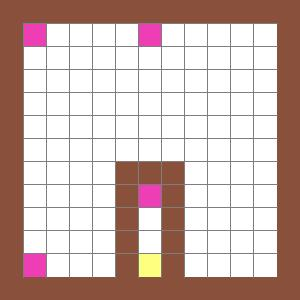

In [3]:
#@title Game 1:  Experiment Mode.

level = 'L1'
game_type = 'experiment'

game_keeper = GameKeeper(game_type, level)
img = Img(game_keeper.obs, brighten_factor=2.5)
output.register_callback('notebook.UpdateImg', game_keeper.move)

display(IPython.display.Javascript('''
      document.addEventListener("keydown", async function(e){
      const result = await google.colab.kernel.invokeFunction(
        'notebook.UpdateImg', // The callback name.
        [e.key], // The arguments.
        {}); // kwargs
    });
'''))
img

Once you have an idea of what the reward is, in the map shown below, enter what you think the reward should be for the path taken in blue (when the path leads to an object, assume the agent went onto the object). Try to experiment a few times before looking at the solution in the cell!


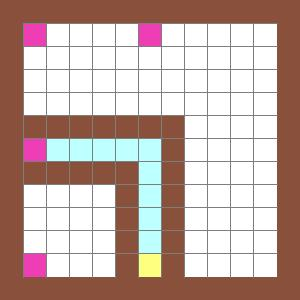

In [4]:
#@title Game 1:  Evaluation Map

level = 'L1'
game_type = 'eval'

game_keeper = GameKeeper(game_type, level)
img_eval = Img(game_keeper.obs, brighten_factor=2.5)
img_eval

In [5]:
# @title Fill out answers
reward = 0  #@param {type:"number"}


if check_g1_exp(reward):
  print("That's right! The agent will get a reward of 3.0!")
else:
  print("Oh no! That wasn't right. Try again :)")

Oh no! That wasn't right. Try again :)


What is the *maximum* reward any agent could get on the second map?

In [6]:
maximum_possible_reward = 0  #@param {type:"number"}
if check_g1_test(maximum_possible_reward):
  print("That's right! The agent can get a maximum reward of 3.0!")
else:
  print("Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?")

Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?


## Game 2: Can you figure out the reward rule?

Alright! Now that we're warmed up, lets look at another game. Remember... this is a completely new game in a new world with its own rules!

<IPython.core.display.Javascript object>


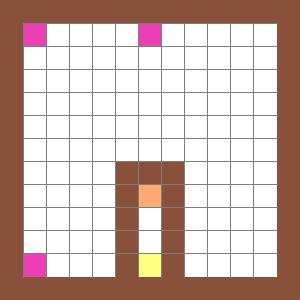

In [7]:
#@title Game 2:  Experiment Mode.

level = 'L2'
game_type = 'experiment'

game_keeper = GameKeeper(game_type, level, per_timestep_reward=-1.0)
img = Img(game_keeper.obs, brighten_factor=2.5)
output.register_callback('notebook.UpdateImg', game_keeper.move)

display(IPython.display.Javascript('''
      document.addEventListener("keydown", async function(e){
      const result = await google.colab.kernel.invokeFunction(
        'notebook.UpdateImg', // The callback name.
        [e.key], // The arguments.
        {}); // kwargs
    });
'''))
img

Can you come up with multiple hypotheses to explain your observations? Are they falsifiable? Try to eliminate your hypothesis until only one is left!

In the map shown below, enter what you think the reward should be for the path taken in blue (when the path leads to an object, assume the agent went onto the object). Try to experiment a few times before looking at the solution in the cell!


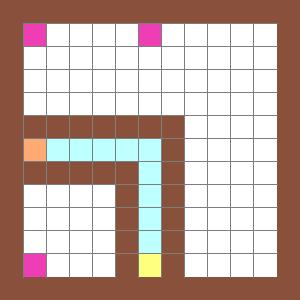

In [8]:
#@title Game 2:  Evaluation Map

level = 'L2'
game_type = 'eval'

game_keeper = GameKeeper(game_type, level, per_timestep_reward=-1.0)
img_eval = Img(game_keeper.obs, brighten_factor=2.5)
img_eval

In [20]:
# @title Fill out answers
reward = -1  #@param {type:"number"}


if check_g2_exp(reward):
  print("That's right! The agent will get a reward of -10.!")
else:
  print("Oh no! That wasn't right. Try again :)")


Oh no! That wasn't right. Try again :)


In [21]:
maximum_possible_reward = -1  #@param {type:"number"}
if check_g2_test(maximum_possible_reward):
  print("That's right! The agent can get a maximum reward of 0.0!")
else:
  print("Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?")

Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?


## Game 3: Can you figure out the reward rule?

OK! Lets do one more map. Remember - each new map is a whole new world with its own rules. All we have is our science toolbox to help us along the way...

<IPython.core.display.Javascript object>


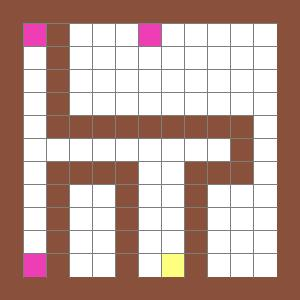

In [11]:
#@title Game 3:  Experiment Mode.

level = 'L3'
game_type = 'experiment'

game_keeper = GameKeeper(game_type, level)
img = Img(game_keeper.obs, brighten_factor=2.5)
output.register_callback('notebook.UpdateImg', game_keeper.move)

display(IPython.display.Javascript('''
      document.addEventListener("keydown", async function(e){
      const result = await google.colab.kernel.invokeFunction(
        'notebook.UpdateImg', // The callback name.
        [e.key], // The arguments.
        {}); // kwargs
    });
'''))
img

Sometimes it helps to write down our hypothesis and what assumptions they each make. When we write things down explicitly, Occam's razor can often help us figure out what is most likely to be true!

In the map shown below, enter what you think the reward should be for the path taken in blue (when the path leads to an object, assume the agent went onto the object). Try to experiment a few times before looking at the solution in the cell!


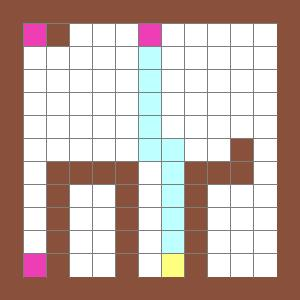

In [12]:
#@title Game 3:  Evaluation Map

level = 'L3'
game_type = 'eval'

game_keeper = GameKeeper(game_type, level)
img_eval = Img(game_keeper.obs, brighten_factor=2.5)
img_eval

In [17]:
# @title What reward would the agent get?
reward = -123  #@param {type:"number"}


if check_g3_exp(reward):
  print("That's right! The agent will get a reward of 0.0!")
else:
  print("Oh no! That wasn't right. Try again :)")


Oh no! That wasn't right. Try again :)


In [18]:
maximum_possible_reward = -123  #@param {type:"number"}
if check_g3_test(maximum_possible_reward):
  print("That's right! The agent can get a maximum reward of 10.0!")
else:
  print("Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?")

Oh no! That wasn't the maximum reward :( What is the best thing the agent can do here?
